# Trigger plots

Generate various plots to show which years triggered with which sources.

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
import ocha_stratus as stratus
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import numpy as np

from src.datasources import grrr, glofas
from src.constants import *

In [3]:
gf_thresh = 3132
gf_lt_max = 5
grrr_thresh = 1195

## Load and process data

### GloFAS reforecast

In [4]:
# df_ref_ens = pd.read_parquet(
#     glofas.GF_PROC_DIR / "wuroboki_glofas_reforecast_ens.parquet"
# )
# just use temp to avoid syncing Drive
df_ref_ens = pd.read_parquet("temp/wuroboki_glofas_reforecast_ens.parquet")

In [5]:
df_gf_ref = (
    df_ref_ens.groupby(["valid_time", "leadtime"])["dis24"]
    .mean()
    .reset_index()
)

In [6]:
df_gf_ref_peaks = (
    df_gf_ref.groupby([df_gf_ref["valid_time"].dt.year, "leadtime"])["dis24"]
    .max()
    .reset_index()
    .rename(columns={"valid_time": "year", "dis24": "dis24_f"})
)

In [7]:
df_gf_ref_peaks_any_lt = (
    df_gf_ref_peaks[df_gf_ref_peaks["leadtime"] <= gf_lt_max]
    .groupby("year")["dis24_f"]
    .max()
    .reset_index()
)

### GloFAS reanalysis

In [8]:
df_gf_rea = glofas.load_glofas_reanalysis(station_name="wuroboki")

In [9]:
df_gf_rea_peaks = (
    df_gf_rea.groupby(df_gf_rea["time"].dt.year)["dis24"]
    .max()
    .reset_index()
    .rename(columns={"time": "year", "dis24": "dis24_a"})
)

### Google forecast

In [10]:
ds_rf = grrr.load_reforecast()
df_grrr_ref = grrr.process_reforecast(ds_rf)

/Users/tdowning/OCHA/repos/ds-aa-nga-flooding/src/datasources/grrr.py:17: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  return xr.open_zarr(


In [11]:
df_grrr_ref_peaks = (
    df_grrr_ref[df_grrr_ref["valid_time"].dt.year < 2023]
    .groupby([df_grrr_ref["valid_time"].dt.year, "leadtime"])["streamflow"]
    .max()
    .reset_index()
    .rename(columns={"valid_time": "year", "streamflow": "streamflow_f"})
)

In [12]:
df_grrr_ref_peaks_any_lt = (
    df_grrr_ref_peaks.groupby("year")["streamflow_f"].max().reset_index()
)

### Google reanalysis

In [13]:
ds_ra = grrr.load_reanalysis()
df_grrr_rea = grrr.process_reanalysis(ds_ra)

In [14]:
df_grrr_rea_peaks = (
    df_grrr_rea.groupby(df_grrr_rea["valid_time"].dt.year)["streamflow"]
    .max()
    .reset_index()
    .rename(columns={"valid_time": "year", "streamflow": "streamflow_a"})
)

### Floodscan

In [15]:
df_fs_raw = stratus.load_parquet_from_blob(
    f"{PROJECT_PREFIX}/processed/floodscan/fs_benue_pixels_1998_2024.parquet"
)
df_fs = (
    df_fs_raw.groupby("date")["SFED"]
    .mean()
    .reset_index()
    .rename(columns={"date": "valid_time"})
)

In [16]:
df_fs_peaks = (
    df_fs.groupby(df_fs["valid_time"].dt.year)["SFED"].max().reset_index()
)

In [17]:
df_fs_peaks = df_fs_peaks.rename(columns={"valid_time": "year"})

## Combine

In [18]:
df_compare = (
    df_fs_peaks.merge(df_gf_rea_peaks, how="outer")
    .merge(df_gf_ref_peaks_any_lt, how="outer")
    .merge(df_grrr_rea_peaks, how="outer")
    .merge(df_grrr_ref_peaks_any_lt, how="outer")
)

In [19]:
for thresh, ind in [(grrr_thresh, "streamflow"), (gf_thresh, "dis24")]:
    for af in ["a", "f"]:
        df_compare[f"{ind}_{af}_rel"] = df_compare[f"{ind}_{af}"] / thresh

In [20]:
df_compare["max_rel"] = df_compare[
    [x for x in df_compare.columns if "rel" in x]
].max(axis=1)

Just have a look at all the yearly peaks:

In [32]:
df_compare.sort_values("dis24_a", ascending=False)

,year,SFED,dis24_a,dis24_f,streamflow_a,streamflow_f,streamflow_a_rel,streamflow_f_rel,dis24_a_rel,dis24_f_rel,max_rel
9,1988,NaN,7801.156250,NaN,1545.979370,NaN,1.293707,NaN,2.490791,NaN,2.490791
15,1994,NaN,5575.781250,NaN,1629.851074,NaN,1.363892,NaN,1.780262,NaN,1.780262
43,2022,0.269161,5347.171875,4619.898438,1793.780396,1899.741821,1.501071,1.589742,1.707271,1.475063,1.707271
20,1999,0.192214,5244.656250,NaN,1545.005493,NaN,1.292892,NaN,1.674539,NaN,1.674539
6,1985,NaN,5046.875000,NaN,1247.214722,NaN,1.043694,NaN,1.611390,NaN,1.611390
2,1981,NaN,4933.351562,NaN,1321.095093,NaN,1.105519,NaN,1.575144,NaN,1.575144
45,2024,0.169988,4459.265625,NaN,NaN,NaN,NaN,NaN,1.423776,NaN,1.423776
19,1998,0.142014,4300.250000,NaN,1328.853149,NaN,1.112011,NaN,1.373004,NaN,1.373004
8,1987,NaN,4023.500000,NaN,730.906738,NaN,0.611637,NaN,1.284642,NaN,1.284642
13,1992,NaN,3635.500000,NaN,941.745239,NaN,0.788071,NaN,1.160760,NaN,1.160760


## Plot

In [33]:
fs_5yr = df_compare["SFED"].quantile(1 - 1 / 5)
fs_3yr = df_compare["SFED"].quantile(1 - 1 / 3)

In [34]:
fs_color = "crimson"
gf_color = "royalblue"
grrr_color = "darkgreen"

In [35]:
def plot_yearly_maxima(x_col, y_col, **kwargs):
    x_thresh = kwargs["x_thresh"]
    x_color = kwargs["x_color"]
    y_thresh = kwargs["y_thresh"]
    y_color = kwargs["y_color"]

    df_plot = df_compare[["year", x_col, y_col]].copy().set_index("year")
    df_plot = df_plot.dropna()

    print(df_plot.index.min(), df_plot.index.max())

    xmax = df_plot[x_col].max() * 1.1
    ymax = df_plot[y_col].max() * 1.1

    fig, ax = plt.subplots(dpi=200, figsize=(7, 7))

    ax.axvline(x_thresh, color=x_color)
    ax.axvspan(x_thresh, xmax, facecolor=x_color, alpha=0.1)

    ax.axhline(y_thresh, color=y_color)
    ax.axhspan(y_thresh, ymax, facecolor=y_color, alpha=0.1)

    for year, row in df_plot.iterrows():
        fontweight = "bold"
        if row[x_col] > x_thresh and row[y_col] > y_thresh:
            color = "k"
        elif row[x_col] > x_thresh:
            color = x_color
        elif row[y_col] > y_thresh:
            color = y_color
        else:
            fontweight = "normal"
            color = "grey"
        ax.annotate(
            year,
            (row[x_col], row[y_col]),
            color=color,
            fontweight=fontweight,
            va="center",
            ha="center",
        )

    ax.annotate(
        kwargs["y_thresh_text"],
        (0, y_thresh),
        color=y_color,
        fontstyle="italic",
        xytext=(2, 2),
        textcoords="offset points",
    )
    ax.annotate(
        kwargs["x_thresh_text"],
        (x_thresh, 0),
        rotation=90,
        ha="right",
        va="bottom",
        color=x_color,
        fontstyle="italic",
        xytext=(0, 3),
        textcoords="offset points",
    )

    ax.set_xlim((0, xmax))
    ax.set_ylim((0, ymax))
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    return fig, ax

### Reanalysis

1998 2024


Text(0.5, 1.0, 'Floodscan vs. GloFAS reanalysis (1998-2024)')

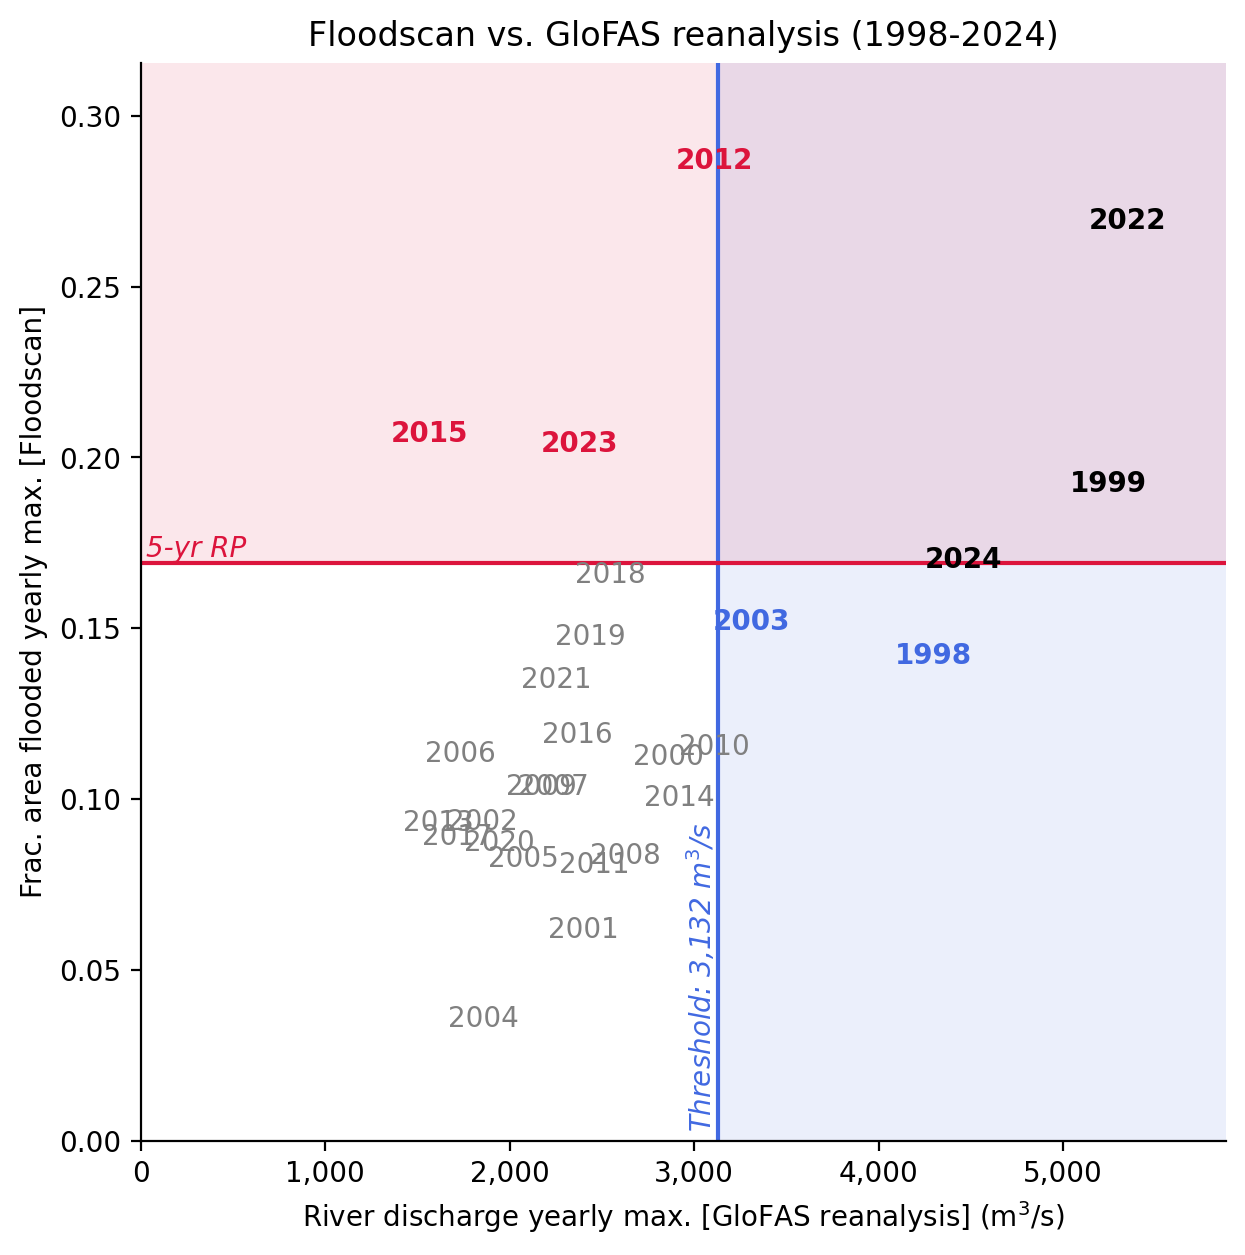

In [36]:
fig, ax = plot_yearly_maxima(
    "dis24_a",
    "SFED",
    x_thresh=gf_thresh,
    x_color=gf_color,
    x_thresh_text=f"Threshold: {gf_thresh:,} m$^3$/s",
    y_thresh=fs_5yr,
    y_color=fs_color,
    y_thresh_text="5-yr RP",
)

ax.xaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))
ax.set_xlabel("River discharge yearly max. [GloFAS reanalysis] (m$^3$/s)")
ax.set_ylabel("Frac. area flooded yearly max. [Floodscan]")
ax.set_title("Floodscan vs. GloFAS reanalysis (1998-2024)")

1998 2023


Text(0.5, 1.0, 'Floodscan vs. Google reanalysis (1998-2023)')

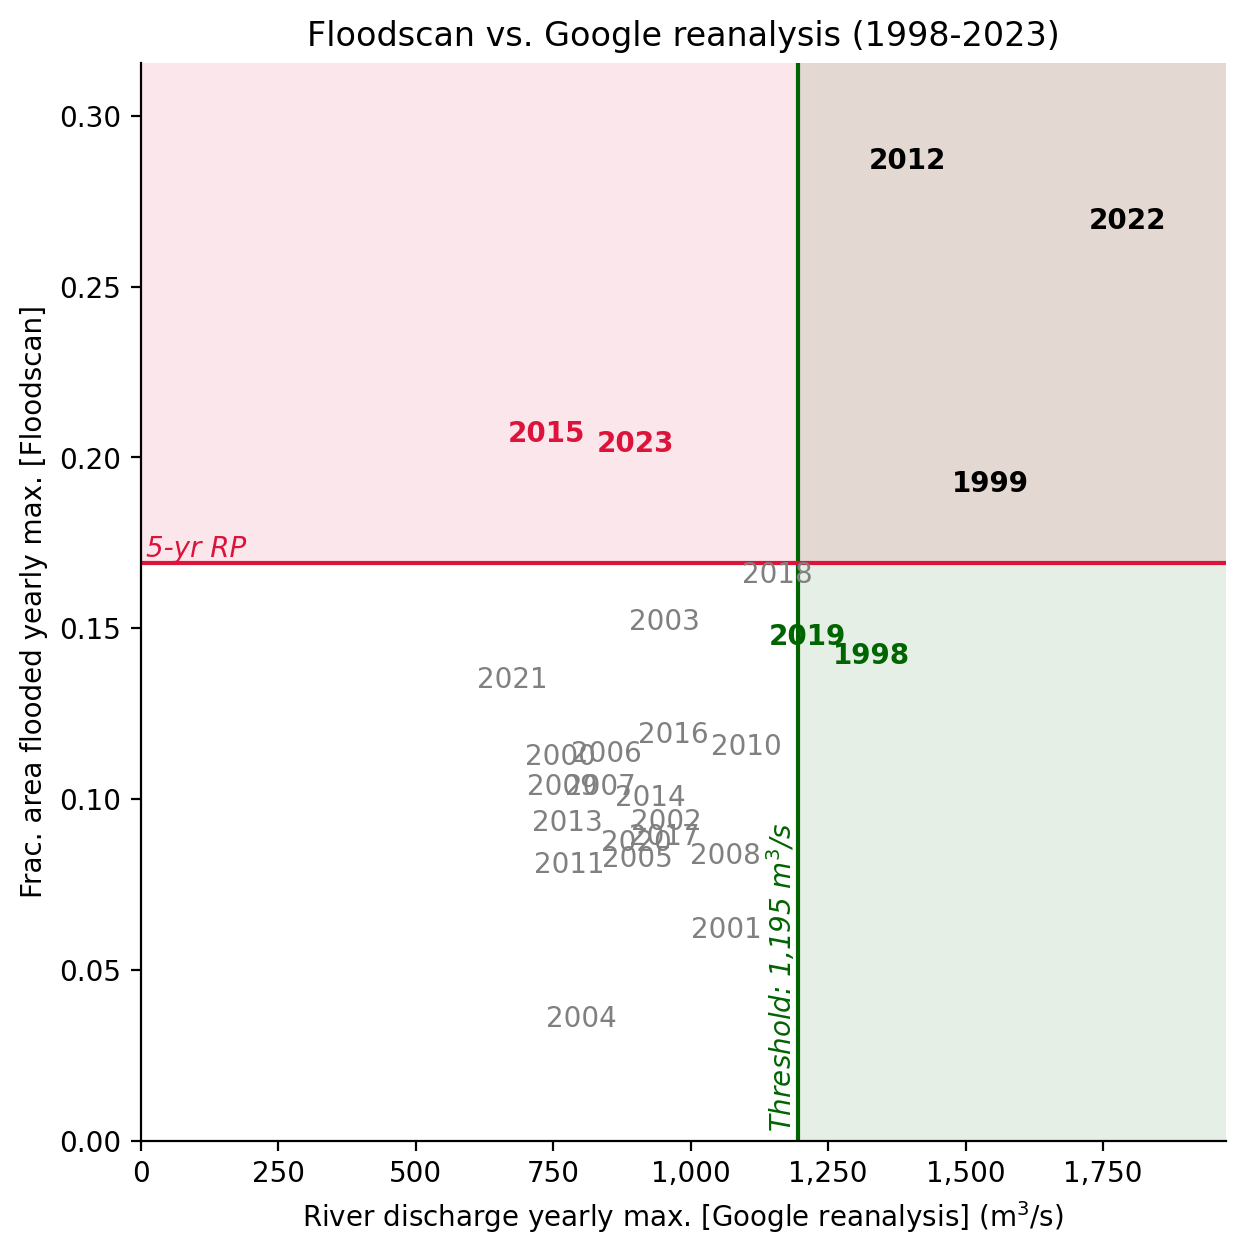

In [37]:
fig, ax = plot_yearly_maxima(
    "streamflow_a",
    "SFED",
    x_thresh=grrr_thresh,
    x_color=grrr_color,
    x_thresh_text=f"Threshold: {grrr_thresh:,} m$^3$/s",
    y_thresh=fs_5yr,
    y_color=fs_color,
    y_thresh_text="5-yr RP",
)

ax.xaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))
ax.set_xlabel("River discharge yearly max. [Google reanalysis] (m$^3$/s)")
ax.set_ylabel("Frac. area flooded yearly max. [Floodscan]")
ax.set_title("Floodscan vs. Google reanalysis (1998-2023)")

1980 2023


Text(0.5, 1.0, 'Google vs. GloFAS reanalysis (1980-2023)')

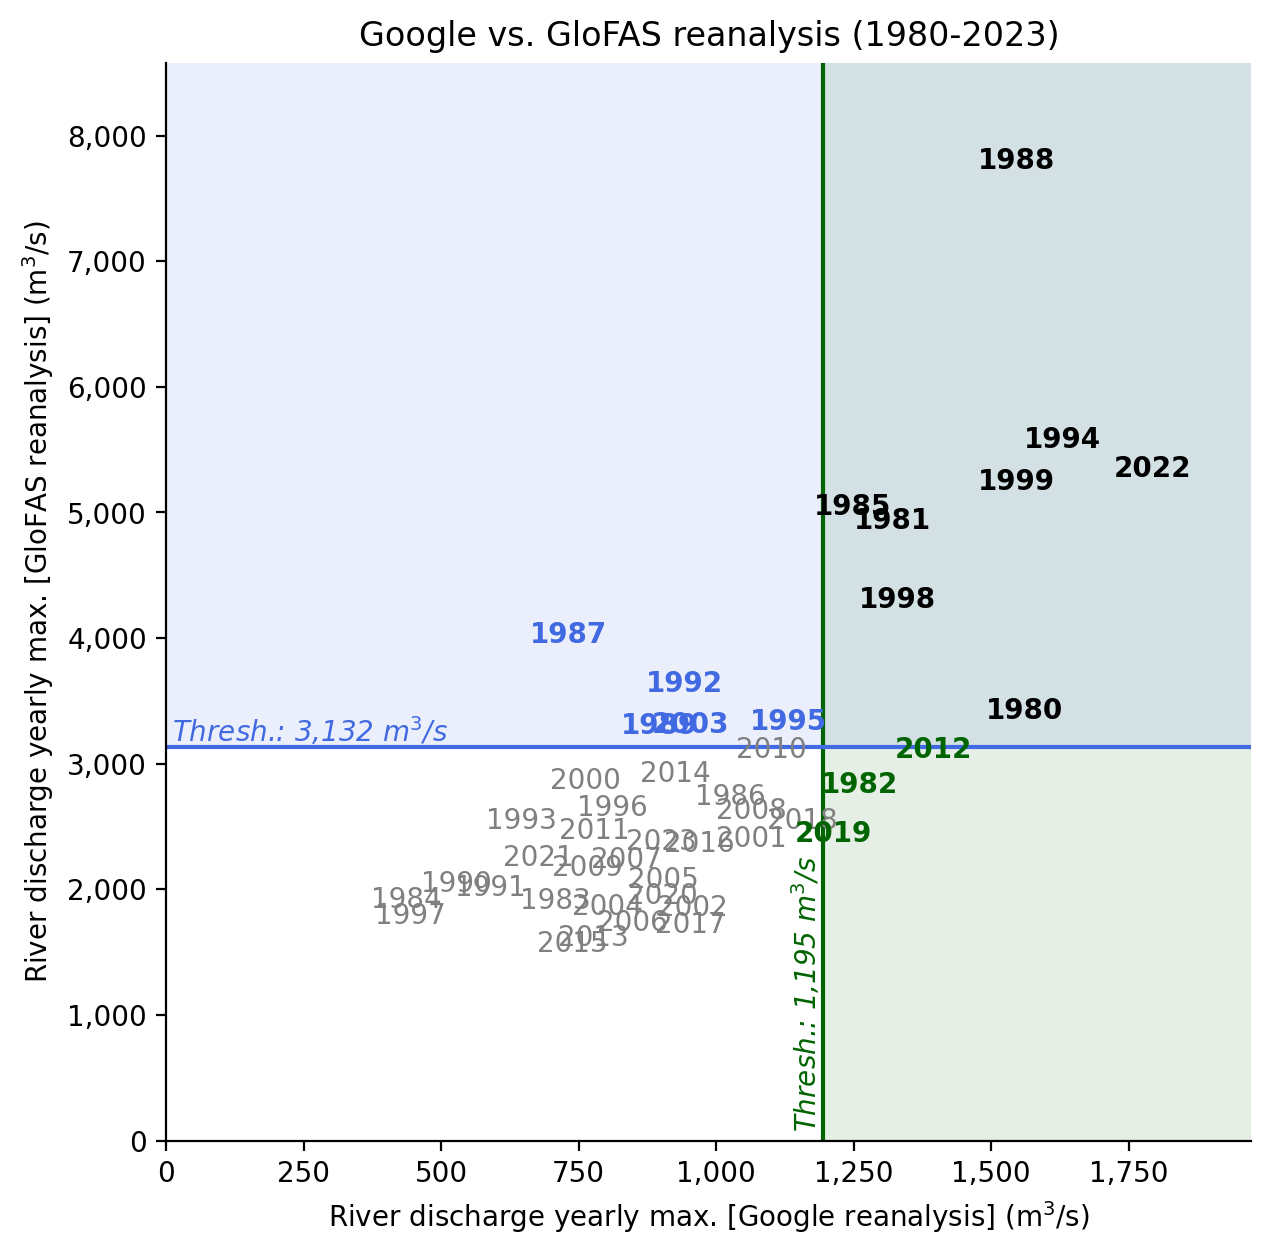

In [38]:
fig, ax = plot_yearly_maxima(
    "streamflow_a",
    "dis24_a",
    x_thresh=grrr_thresh,
    x_color=grrr_color,
    x_thresh_text=f"Thresh.: {grrr_thresh:,} m$^3$/s",
    y_thresh=gf_thresh,
    y_color=gf_color,
    y_thresh_text=f"Thresh.: {gf_thresh:,} m$^3$/s",
)

ax.set_xlabel("River discharge yearly max. [Google reanalysis] (m$^3$/s)")
ax.set_ylabel("River discharge yearly max. [GloFAS reanalysis] (m$^3$/s)")
ax.xaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))
ax.set_title("Google vs. GloFAS reanalysis (1980-2023)")

### Reforecast

2003 2022


Text(0.5, 1.0, 'Floodscan vs. GloFAS forecast (2003-2022)')

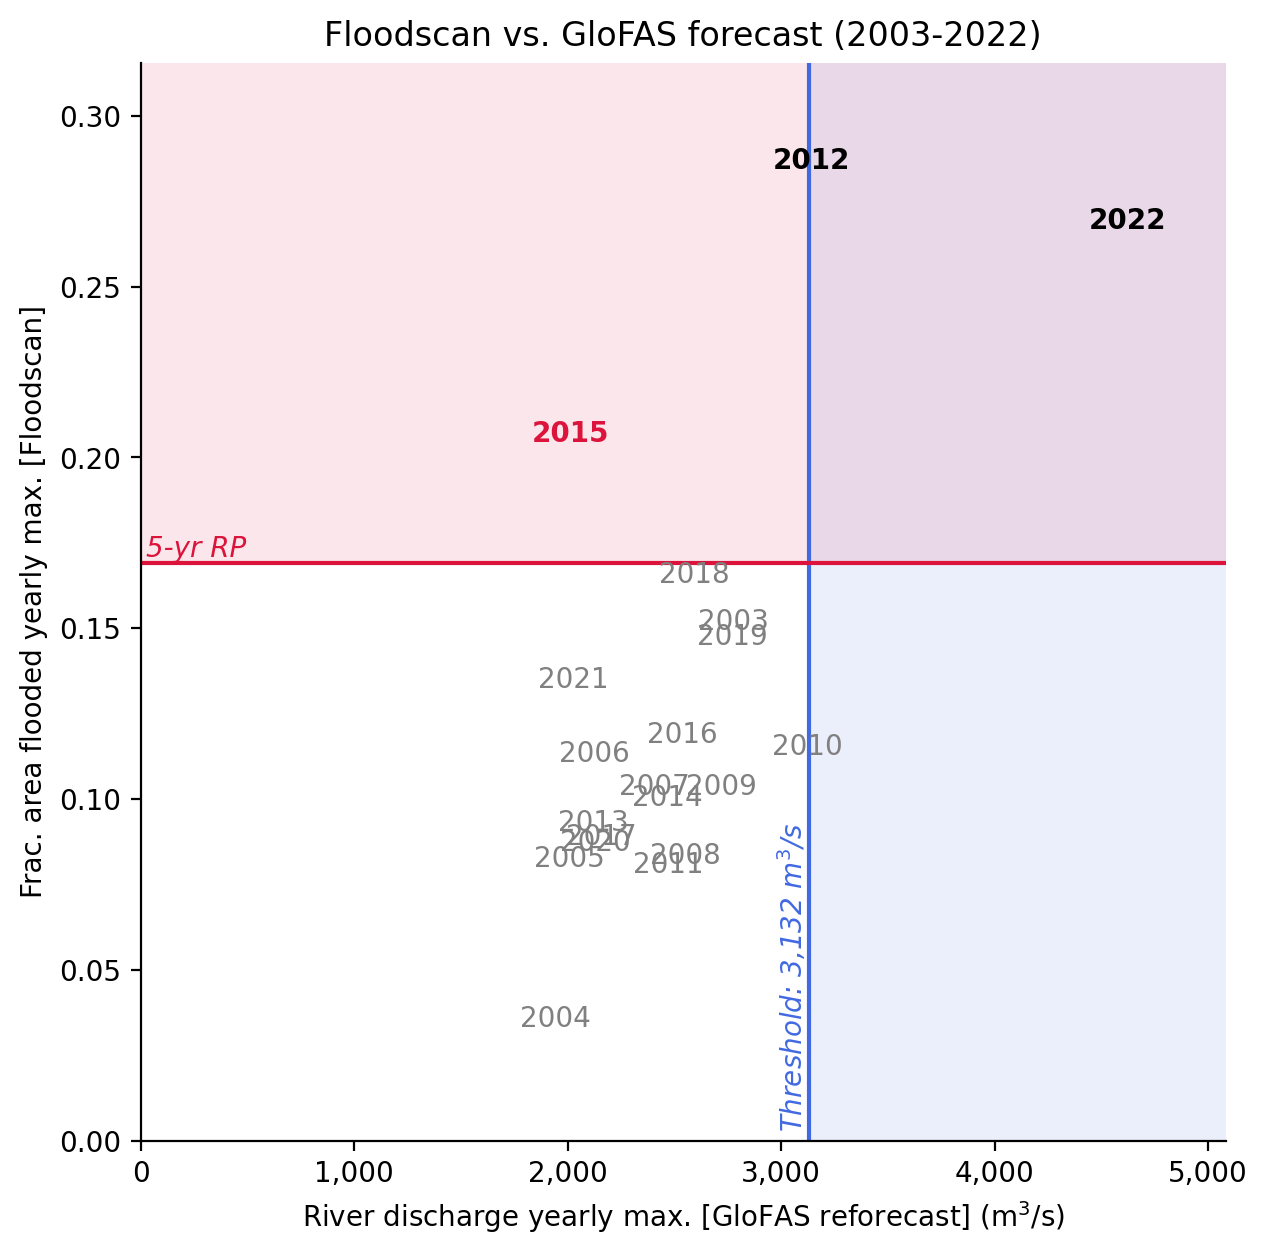

In [39]:
fig, ax = plot_yearly_maxima(
    "dis24_f",
    "SFED",
    x_thresh=gf_thresh,
    x_color=gf_color,
    x_thresh_text=f"Threshold: {gf_thresh:,} m$^3$/s",
    y_thresh=fs_5yr,
    y_color=fs_color,
    y_thresh_text="5-yr RP",
)

ax.xaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))
ax.set_xlabel("River discharge yearly max. [GloFAS reforecast] (m$^3$/s)")
ax.set_ylabel("Frac. area flooded yearly max. [Floodscan]")
ax.set_title("Floodscan vs. GloFAS forecast (2003-2022)")

2016 2022


Text(0.5, 1.0, 'Floodscan vs. Google forecast (2016-2022)')

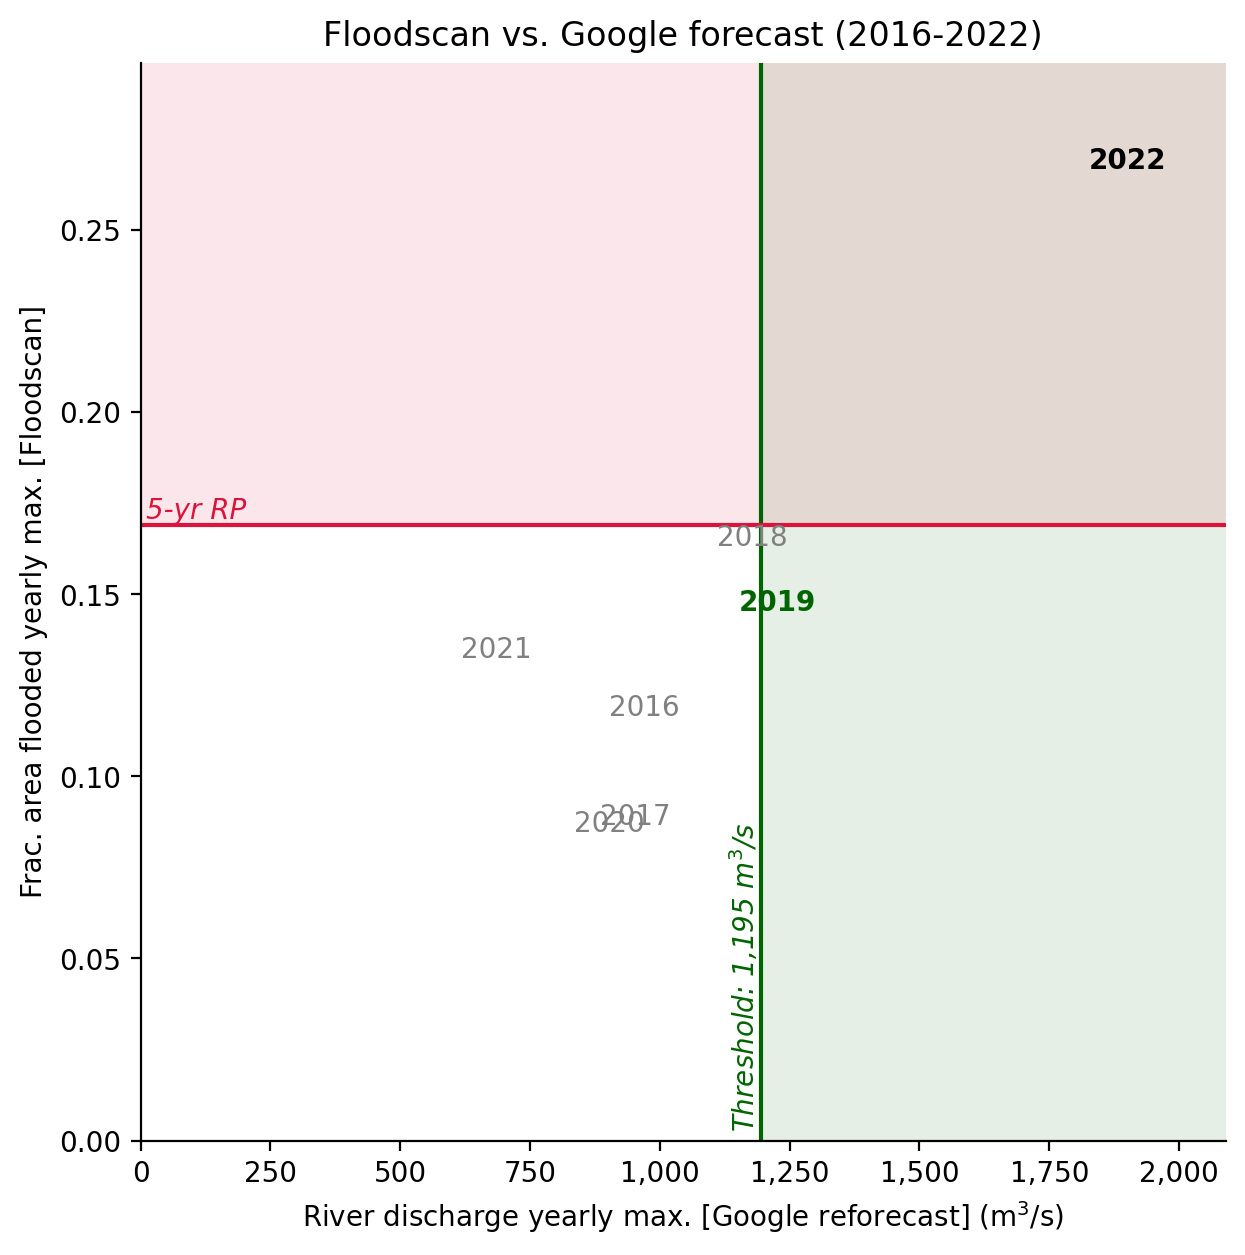

In [40]:
fig, ax = plot_yearly_maxima(
    "streamflow_f",
    "SFED",
    x_thresh=grrr_thresh,
    x_color=grrr_color,
    x_thresh_text=f"Threshold: {grrr_thresh:,} m$^3$/s",
    y_thresh=fs_5yr,
    y_color=fs_color,
    y_thresh_text="5-yr RP",
)

ax.xaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))
ax.set_xlabel("River discharge yearly max. [Google reforecast] (m$^3$/s)")
ax.set_ylabel("Frac. area flooded yearly max. [Floodscan]")
ax.set_title("Floodscan vs. Google forecast (2016-2022)")

### Either

1998 2024


Text(0.5, 1.0, 'Floodscan vs. combined flood forecast')

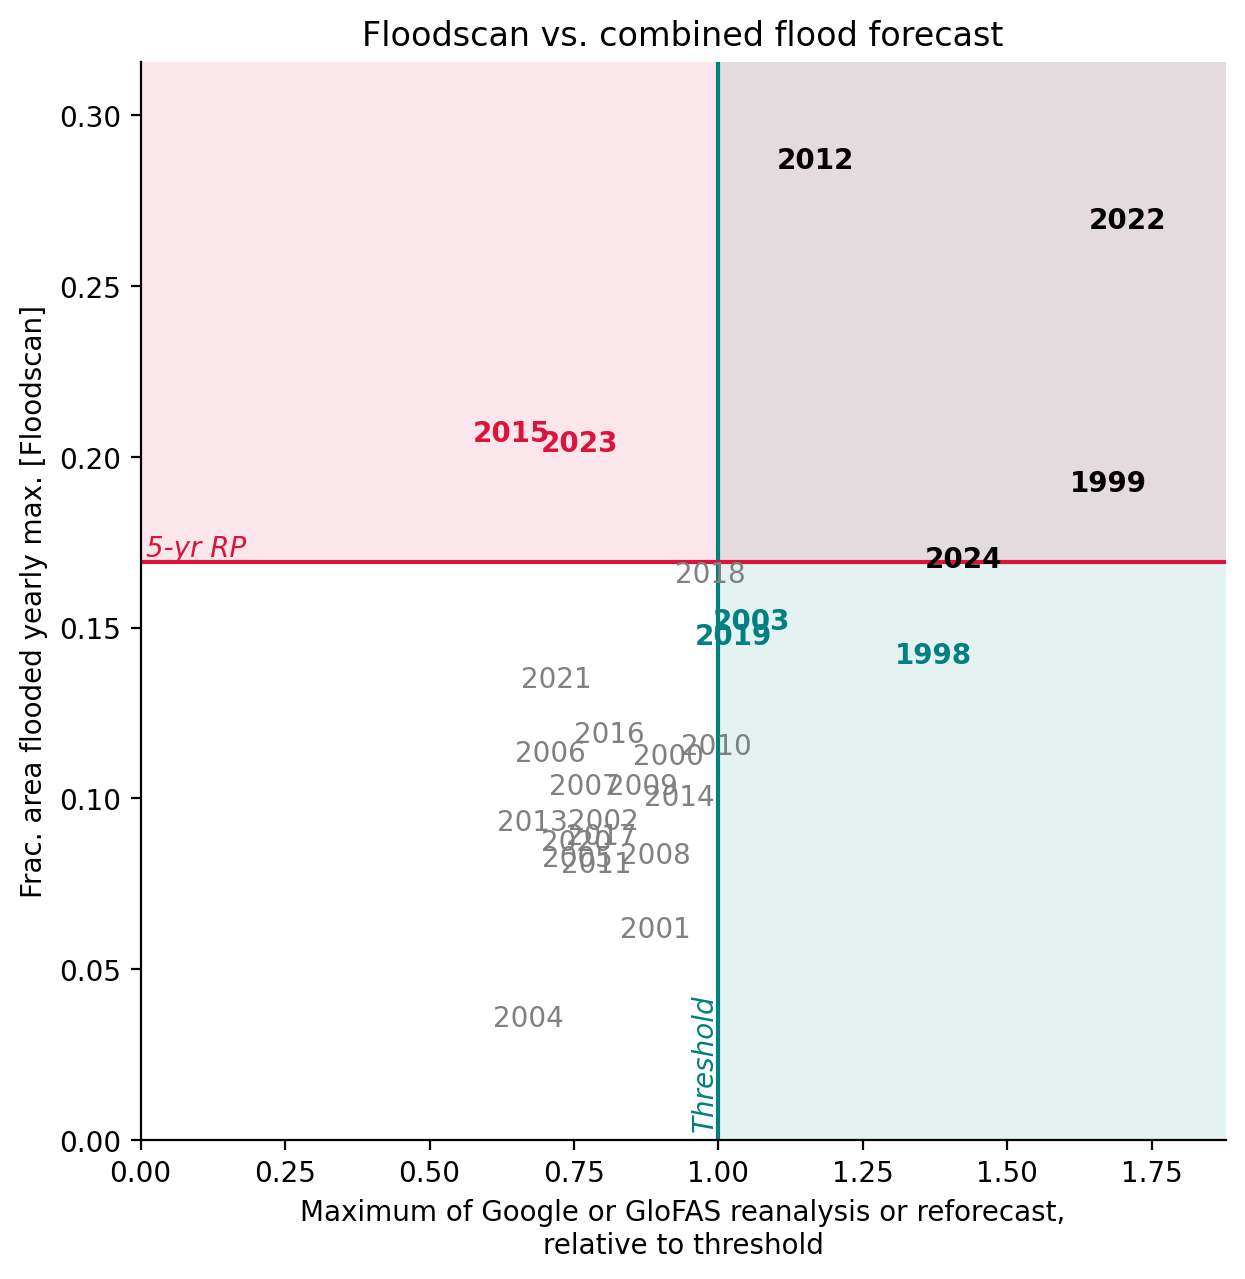

In [41]:
fig, ax = plot_yearly_maxima(
    "max_rel",
    "SFED",
    x_thresh=1,
    x_color="teal",
    x_thresh_text="Threshold",
    y_thresh=fs_5yr,
    y_color=fs_color,
    y_thresh_text="5-yr RP",
)

ax.set_xlabel(
    "Maximum of Google or GloFAS reanalysis or reforecast,\n"
    "relative to threshold"
)
ax.set_ylabel("Frac. area flooded yearly max. [Floodscan]")
ax.set_title("Floodscan vs. combined flood forecast")